# Use case 5: Camera images

In [1]:
import ToyModel as tm
import numpy as np
import matplotlib.pyplot as plt

This package allows for the production of an `Image` object that contains a time-varying shower image calculated from a `Signal` object and some parameters of the telescope camera (i.e., the number of pixels and the integration time of a camera frame). Notice that a `Signal` object only has information for discrete points in a linear shower. Nonetheless, the camera image is emulated by spreading the signal due to each shower point over the area on the camera corresponding to the projection of a cylinder of one Molière radius and lenght equal to the track discretization step centered at this shower point.

The procedure is the following. For each shower point within the telescope FoV, several samples at several lenghts and radii with random angles around the shower axis are generated. The number os samples is chosen so that the angular separation between samples matches approximately with the camera pixel size. Then, the photoelectrons corresponding to this shower point are distributed among these samples as a function of radius according to the Nishimura-Kamata-Greisen lateral profile, but still assuming that they are produced at the same time in the camera. Finally, the number of photoeletrons at each camera frame and each pixel is computed by summing the contribution from the samples of all the shower points. For that purpuse, a circular camera with square pixels of same solid angle is assumed.

### Construction of an `Image` object

The default `Image` object is calculated taking the number of pixels `N_pix` and the integration time of a camera frame `int_time` predefined by the `Telescope` object used to generate the `Signal` object, but these parameters can be modified when constructing the `Image` object. The pixel values at each camera frame are stored in the attribute `frames`, which is an array of dimensions (`N_frames`, 2x`N_pix_r`+1, 2x`N_pix_r`+1), where `N_frames` is the number of frames spanned by the shower signal and `N_pix_r` is the number of pixels across a camera radius. Matrix elements outside the circular camera are set to -infinity ("blanck pixels").

In [2]:
shower = tm.Shower(x0=0.2, y0=0.1, theta=20., az=45.)
telescope = tm.Telescope(theta=22., az= 44.)  # Placed at the origin of coordinates
signal = tm.Signal(telescope, shower)

# Default Image object for the default telescope type
image1 = tm.Image(signal)
print("image1")
print("Number of pixels:", image1.N_pix)
print("Number of pixels across a camera radius:", image1.N_pix_r)
print("Integration time in microseconds:", image1.int_time)
print("Dimensions of frames:", image1.frames.shape)

# Setting N_pix and int_time
image2 = tm.Image(signal, N_pix=3000, int_time=0.002)
print("image2")
print("Number of pixels:", image2.N_pix)
print("Number of pixels across a camera radius:", image2.N_pix_r)
print("Integration time in microseconds:", image2.int_time)
print("Dimensions of frames", image2.frames.shape)

image1
Number of pixels: 1800
Number of pixels across a camera radius: 24
Integration time in microseconds: 0.01
Dimensions of frames: (4, 49, 49)
image2
Number of pixels: 3000
Number of pixels across a camera radius: 31
Integration time in microseconds: 0.002
Dimensions of frames (16, 63, 63)


The signal spreading may be turned off to obtain the image of a linear shower.

In [3]:
image1 = tm.Image(signal)  # lat_profile=True
sum1 = image1.frames.sum(0)  # Sum of frames
n1 = len(sum1[sum1>0.].flat)
print("Number of triggered pixels with signal spreading:", n1)

image2 = tm.Image(signal, lat_profile=False)
sum2 = image2.frames.sum(0)
n2 = len(sum2[sum2>0.].flat)
print("Number of triggered pixels for a linear shower:", n2)

Number of triggered pixels with signal spreading: 1785
Number of triggered pixels for a linear shower: 27


The mean number of background photoelectrons per camera frame and pixel is also calculated. A night sky background of 40 MHz/m$^2$/deg$^2$ is assumed by default, but this parameter can be changed.

In [4]:
image1 = tm.Image(signal, N_pix=3000, int_time=0.002)  # NSB=40.
print("image1")
print("NSB in MHz/m$^2$/deg$^2$:", image1.NSB)
print("Mean number of background photoelectrons per pixel and frame:", image1.NSB_pix)

# Setting the night sky background
image2 = tm.Image(signal, N_pix=1500, int_time=0.002, NSB=30.)  # Double size pixels but lower NSB
print("image2")
print("NSB in MHz/m$^2$/deg$^2$:", image2.NSB)
print("Mean number of background photoelectrons per pixel and frame:", image2.NSB_pix)

image1
NSB in MHz/m$^2$/deg$^2$: 40.0
Mean number of background photoelectrons per pixel and frame: 0.03788377796794863
image2
NSB in MHz/m$^2$/deg$^2$: 30.0
Mean number of background photoelectrons per pixel and frame: 0.056825666951922954


Help on `Image` constructor

In [5]:
# tm.Image?

Help on `Image` objects

In [6]:
# image2?

### Image visualization

`Image` objects have a `show` method to visualize the camera image in a color map. By default, the sum of frames is shown and a random background generated with Poisson distribution with mean `NSB_pix` is added to each pixel. However, one can select a specific frame (from 0 to `N_frames`-1) and change the NSB value to generate the image.

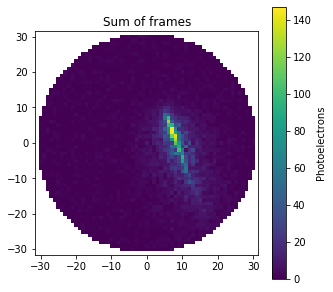

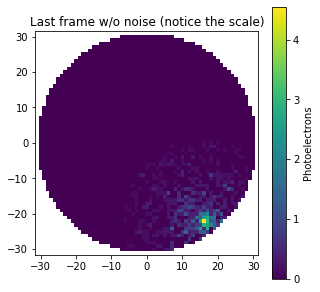

In [7]:
image = tm.Image(signal, N_pix=3000)
last_frame = image.N_frames - 1

# Default visualization
ax1 = image.show();
ax1.set_title("Sum of frames");

# Selecting a specific frame and setting NSB to 0
ax2 = image.show(frame=last_frame, NSB=0.);
ax2.set_title("Last frame w/o noise (notice the scale)");

These camera images are not shown in a `theta`/`phi` projection. Instead, a projection that keeps the pixel area constant is used, where the axis labels represent number of pixels across the vertical and horizontal axes from the telescope pointing direction. Nevertheless, the distortion of the image would only be noticeable at large `theta`. Below is an example of a shower observed transversely by a fluorescence telescope with an aperture of 40$^\circ$ (see UC3).

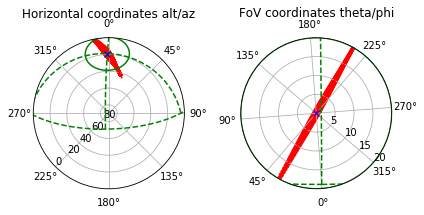

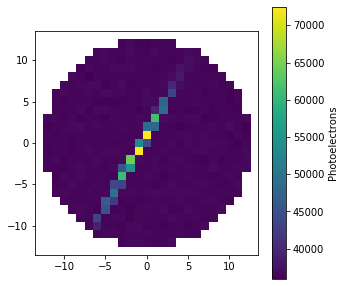

In [8]:
shower_fluo = tm.Shower(E=1.e12, prf_model='Gaisser-Hillas', X_max=500., x0=-2.5, y0=12., theta=45., az=20.)
telescope_fluo = tm.Telescope(apert=40., N_pix=500, int_time=1.)
distance, alt, az, theta, phi = telescope_fluo.spherical(*shower_fluo.track.X_to_xyz(500.))
telescope_fluo = telescope_fluo.copy(alt=alt, az=az)  # Telescope pointing at shower maximum
signal_fluo = tm.Signal(shower_fluo, telescope_fluo)
image_fluo = tm.Image(signal_fluo)

signal_fluo.show_projection(max_theta=20.);
image_fluo.show();

Note: The parameters `N_pix` and `int_time` should be set adequately for the telescope type and mode of observation (`int_time` is around 10 ns for IACTs, but of the order of 1 us for fluorescence telescopes).

Another method `animate` generates a video of the camera frames. This method also allows one to set the NSB value.

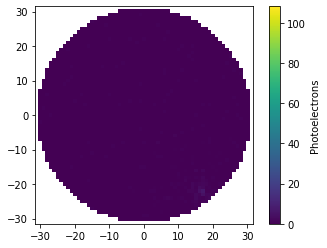

In [9]:
image = tm.Image(signal, N_pix=3000, int_time=0.002)
image.animate()  # Default NSB value

# Very high NSB
# image.animate(NSB=10000.)

# Example of a shower observed by a fluorescence telescope
# image_fluo.animate()

Help on the `show` method of `Image` objects.

In [10]:
# image.show?

Help on the `animate` method of `Image` objects.

In [11]:
# image.animate?

### Figures with several camera images

This package also allows one to produce beautiful figures with several subplots, each one with a different camera image (e.g., for different telescopes and/or different showers). To do that, the `Axes` object where each plot is to be added has to be passed as an input parameter of the `show` method. Below is an example to show camera images of showers with different `theta` angles.

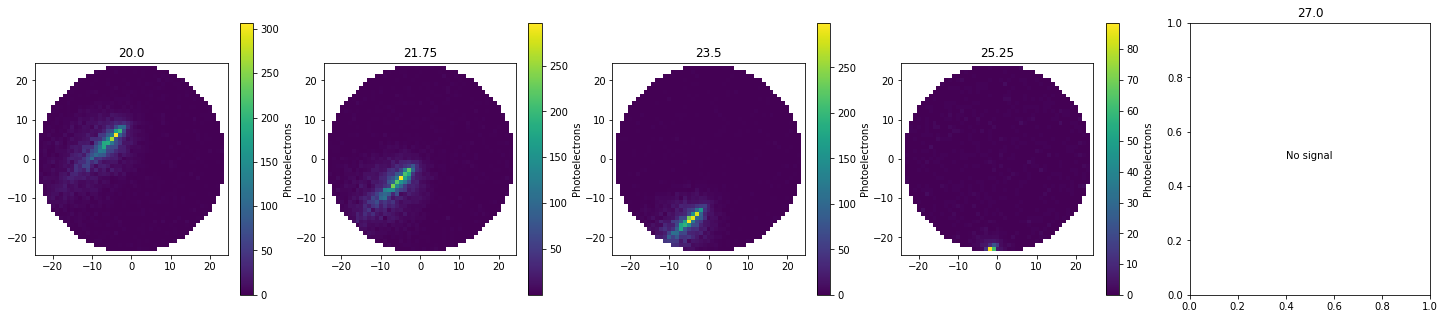

In [12]:
telescope = tm.Telescope(theta=22., az= 44.)
theta = np.linspace(20., 27., 5)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for th, ax in zip(theta, axes):
    shower = tm.Shower(y0=0.2, theta=th, az=45.)
    signal = tm.Signal(telescope, shower)
    image = tm.Image(signal)
    image.show(ax=ax)
    ax.set_title(th)
    

Note: The last subplot is empty because the shower track is outside the telescope field of view.

Two special methods of `Event` objects are also available to do this type of subplot figures. First, the `images` method generates a list of `Image` objects, one for each telescope of the observatory, which is stored as a new attribute of the `Event` object. The `images` method has the input parameters `lat_profile` and `NSB`, but not `N_pix` nor `int_time` (i.e., the predefined values of the constituent telescopes of the `Observatory` object are always used). Second, the `show_images` method generates the corresponding subplot figure, indicating the telescope id. This method has no input parameter.  
Below is an example to generate the 25 camera images using an `Event` object constructed for an `Array25` observatory.

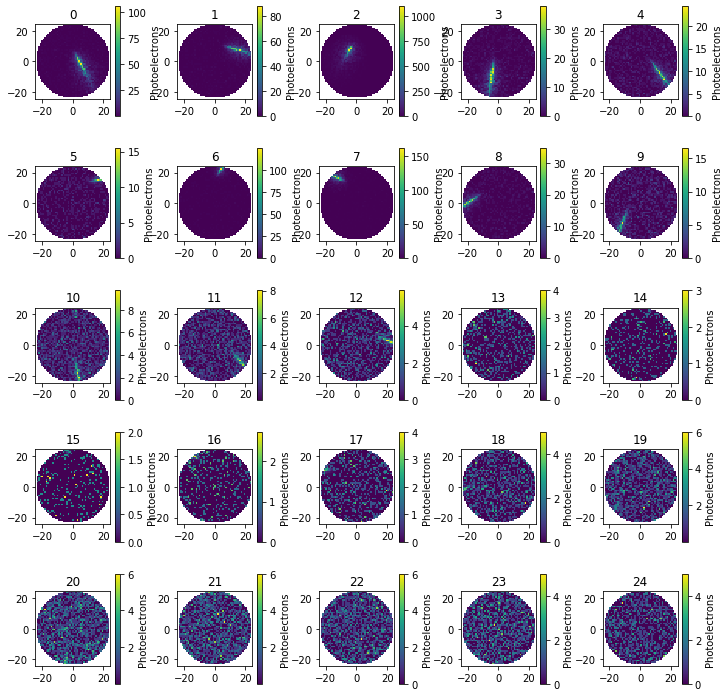

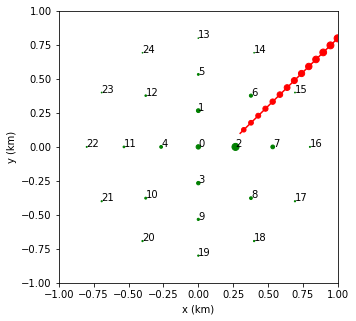

In [13]:
shower = tm.Shower(x0=0.3, y0=0.1, theta=20., az=45.)
observatory = tm.Array25(R=0.8, theta=22., az= 46.)
event = tm.Event(observatory, shower)
event.images(NSB=10.)
event.show_images();
event.show_geometry2D(tel_index=True);